# Кластеризация


В данном ноутбуке мы познакомимся с задачей кластеризации, которая относится к области машинного обучения без учителя. Мы рассмотрим следующие темы:


1.   Алгоритм кластеризации K-средних
2.   Подбор числа кластеров
3.   DBSCAN и подбор параметров для него
4.   Иерархическая кластеризация
5.   Метрики качества кластеризации
6.   Задача понижения размерности

В бонусной части мы дополнительно разберем задачу детекции аномалий.

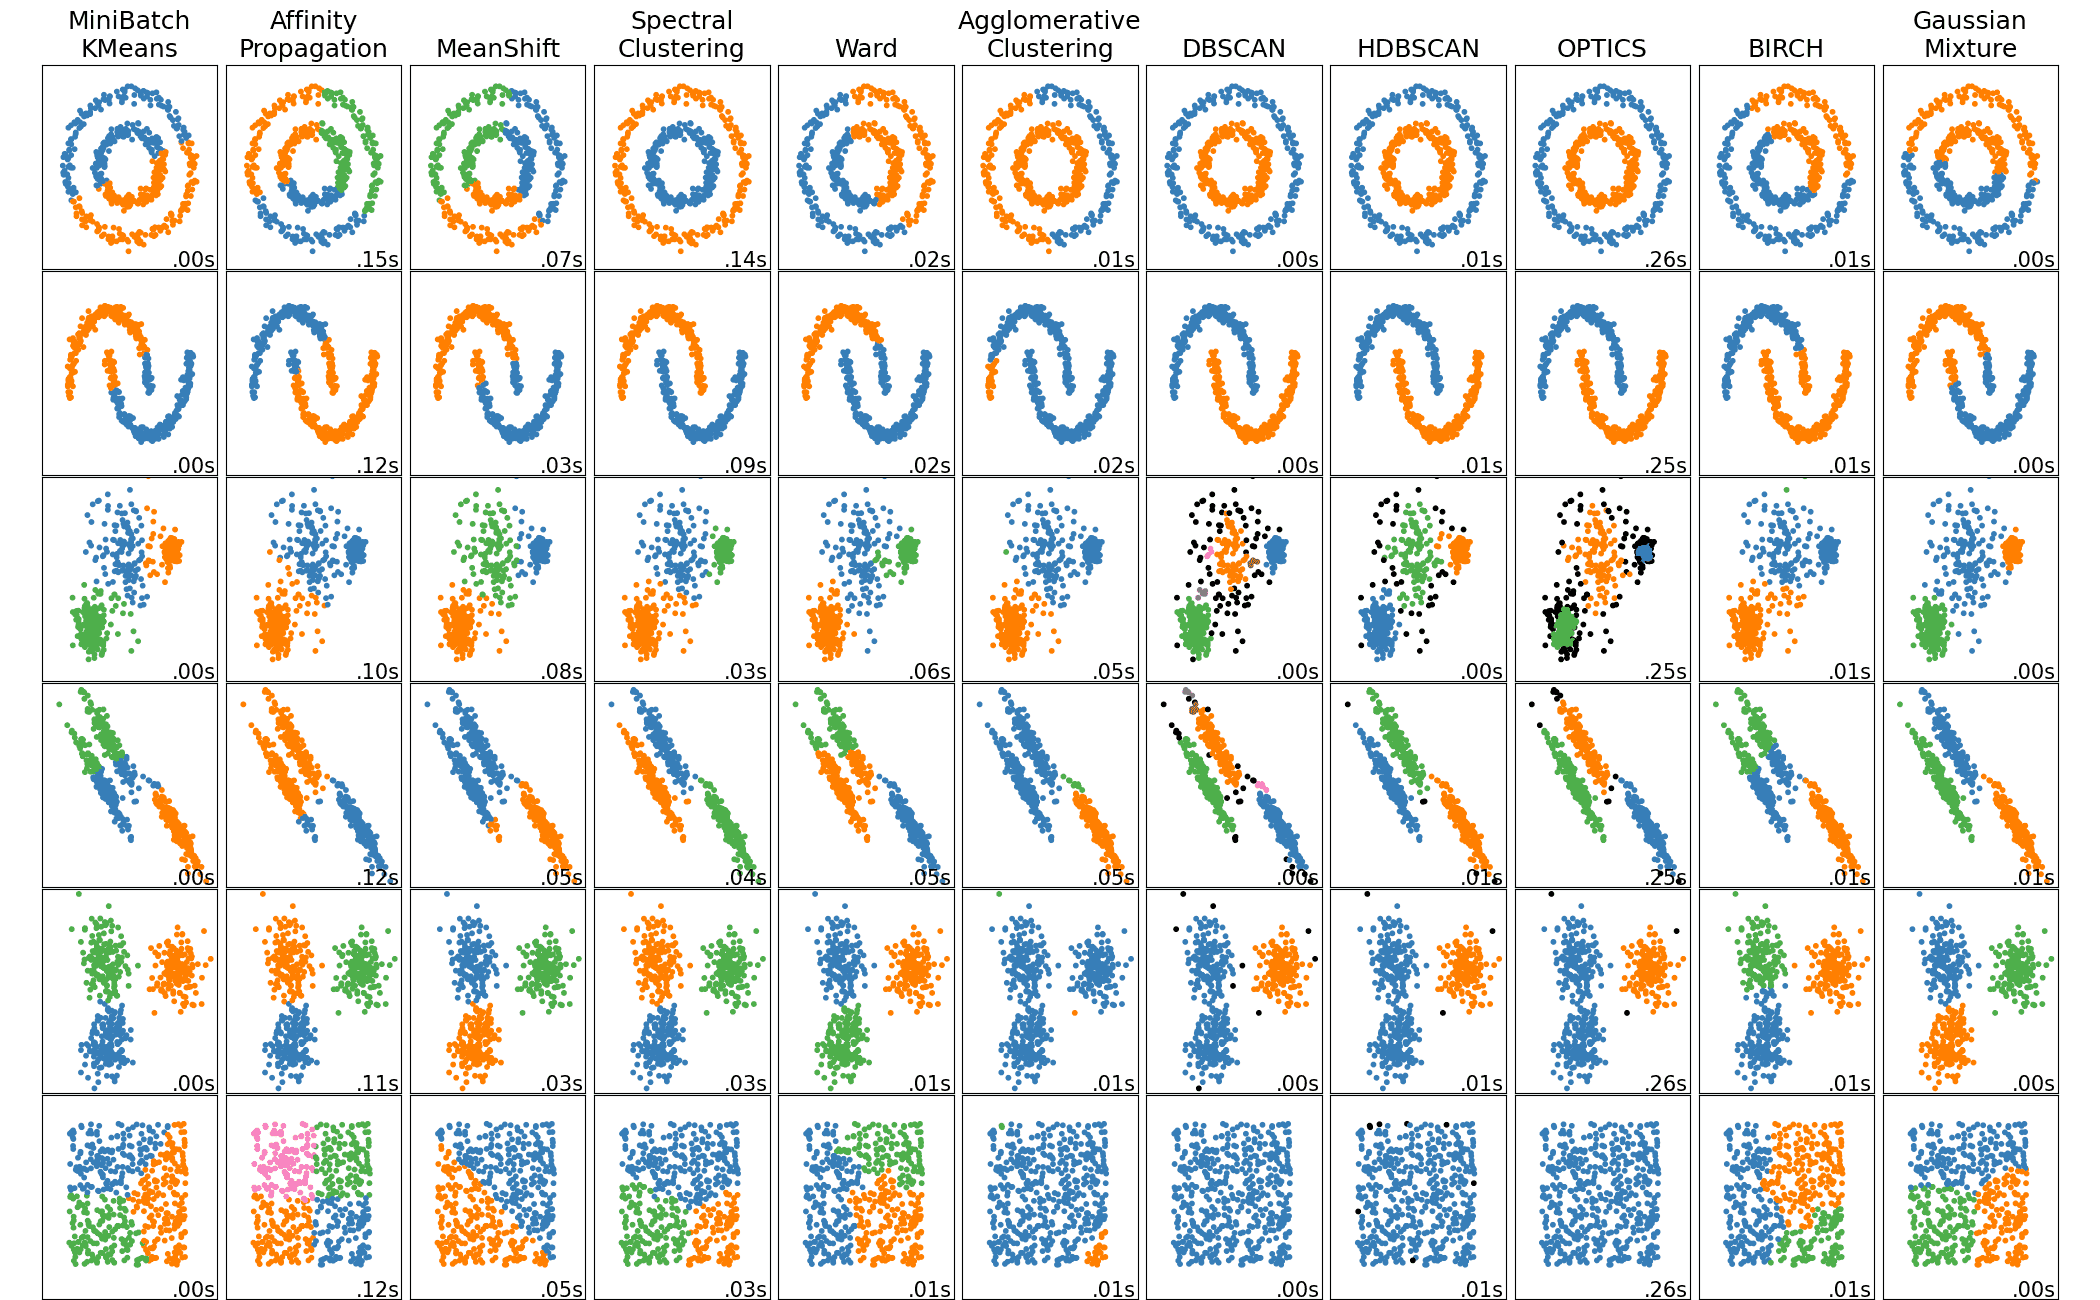

Кластеризация - полезный инструмент в бизнесе. С помощью нее, прежде всего, можно проанализировать большие наборы данных на основе сгруппированных кластеров. Например, разделив данные о пользователях на несколько кластеров, мы сможем понять, какие существуют типы поведения, и адаптировать наш сервис под них.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## K-средних

Алгоритм можно схематически представить в виде следующих шагов:

1. Инициализируем центры кластеров случайно (должно быть задано количество кластеров).
2. Относим точки к соответствующим кластерам (с минимальным расстоянием до их центра).
3. Производится пересчет центров кластеров по формуле центра масс всех точек, принадлежащих кластеру.
4. Пункты 2-3 повторяются до тех пор, пока центры кластеров не перестанут меняться (сильно).

$
\begin{aligned}
& J = \sum_{i=1}^{m} \sum_{j=1}^{k} \lVert x_i - c_j \rVert^2 \\
& \text{где:} \\
& J \text{ - функция потерь (сумма квадратов расстояний)}, \\
& m \text{ - количество обучающих примеров}, \\
& k \text{ - количество кластеров}, \\
& x_i \text{ - } i\text{-й пример}, \\
& c_j \text{ - центр } j\text{-го кластера}.
\end{aligned}
$

Сгенерируем три случайных непересекающихся кластера из нормального распределения с центром в разных точках.

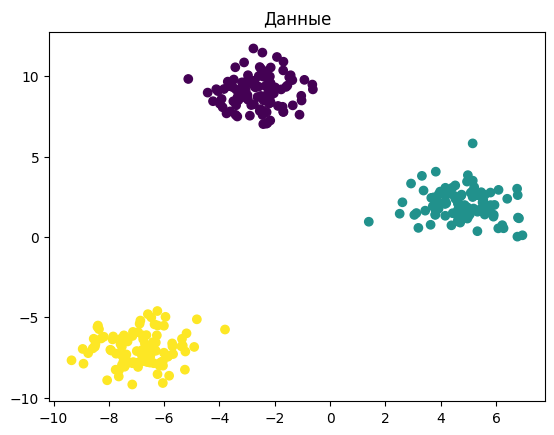

In [ ]:
from sklearn.datasets import make_blobs

# Функция для генерации данных, всего 300 точек и 3 центра
X, y = make_blobs(n_samples=300, centers=3, random_state=42)

# Строим диаграмму рассеивания, каждый класс покрасим в отдельный цвет
plt.scatter(X[:,0], X[:,1], c=y)
plt.title('Данные')
plt.show()

Применим K средних с числом кластеров 3.

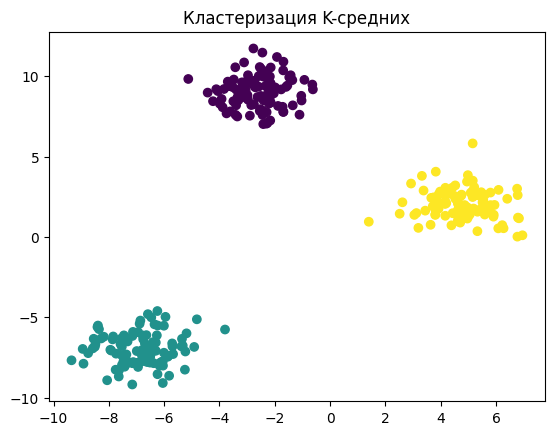

In [ ]:
# Импортируем библиотеку, отвечающую за алгоритм K-средних
from sklearn.cluster import KMeans # Класс, отвечающий за алгоритм K-средних

k_means = KMeans(n_clusters=3, random_state=42) # n_clusters - число кластеров
k_means = k_means.fit(X) # кластеризуем
clusters = k_means.predict(X) # получаем предсказанные кластеры
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.title('Кластеризация K-средних')
plt.show()

Попробуем перебрать количество кластеров от 2 до 7.

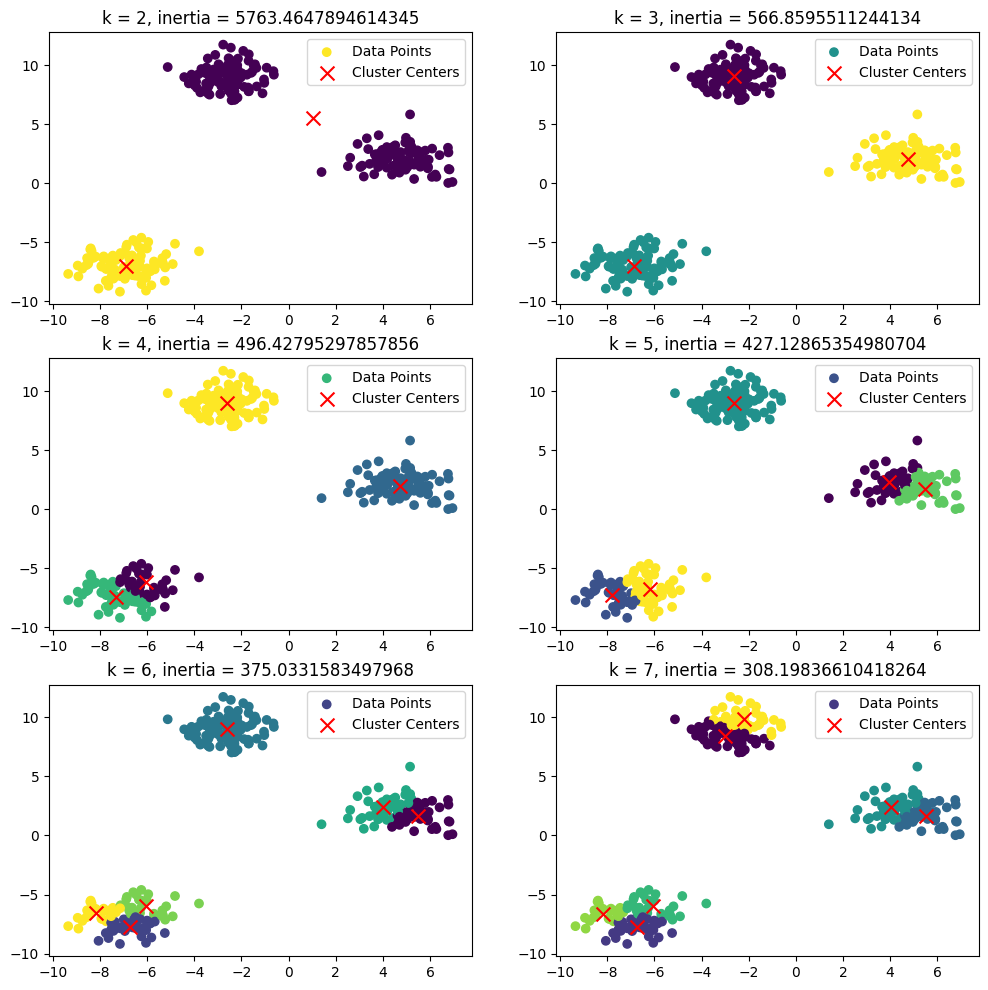

In [ ]:
inertia_values = []
k_values = []

plt.figure(figsize=(12, 12))
for k in range(2, 8): # Итерируемся по количеству кластеров

    # Центры классов также называют центроидами
    # Указываем количество запусков KMeans с разными начальными центроидами - 10
    k_means = KMeans(n_clusters=k, n_init=10, random_state=42)

    k_means = k_means.fit(X)
    clusters = k_means.predict(X)
    cluster_centers = k_means.cluster_centers_  # Выбираем центр кластера
    plt.subplot(3, 2, k - 1)
    plt.scatter(X[:, 0], X[:, 1], c=clusters, label='Data Points')
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red',
                marker='x', s=100, label='Cluster Centers')  # рисуем центроиды
    plt.title('k = {}, inertia = {}'.format(k, k_means.inertia_))
    inertia_values.append(k_means.inertia_) # Добавляем значение инерции
    k_values.append(k)
    plt.legend()
plt.show()

Инерция в K-средних - сумма квадратов расстояний внутри кластеров.

In [ ]:
k_means.inertia_

308.19836610418264

Формула инерции совпадает с той, которую минимизирует алгоритм K-средних

$\begin{aligned}
& \quad I = \sum_{i=1}^{m} \sum_{j=1}^{k}\lVert x_i - c_j \rVert^2 \\
& \text{где:} \\
& I \text{ - инерция (сумма квадратов расстояний)}, \\
& m \text{ - количество обучающих примеров}, \\
& k \text{ - количество кластеров}, \\
& x_i \text{ - } i\text{-й пример}, \\
& c_j \text{ - центр } j\text{-го кластера}.
\end{aligned}$


Правило локтя для определения количества кластеров

1. Запускаем K-средних с разными значениями `n_clusters`.
2. Для каждого значения `n_clusters`, вычисляем инерцию.
3. Строим график инерции относительно `n_clusters`.
4. Находим точку на графике, где инерция начинает менять свой характер (обычно похоже на сгиб). В этой точке число кластеров `n_clusters` будет оптимальным.

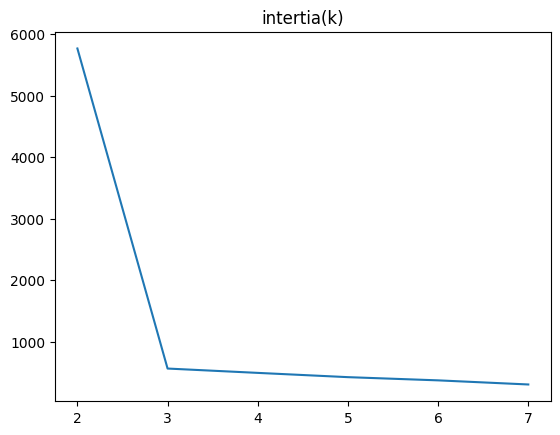

In [ ]:
plt.plot(k_values, inertia_values)
plt.title('intertia(k)')
plt.show()

Как мы видим, K-средних обязательно пытается отдать каждому кластеру какие-то объекты и, как большинство алгоритмов кластеризации, зависит от заданного числа кластеров.

Одним из главных недостатков K средних является случайная инициализация центров кластеров, что может привести к различным результатам кластеризации.

Главным же достоинством является скорость алгоритма. На каждой итерации требуется пересчет только расстояний до центров кластеров.

 **Для интересующихся**

 [В реализации библиотеки Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) помимо количества кластеров, можно указать и много других параметров.

Основные параметры перечислены ниже:

`class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init='warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')`


## Вопрос

Какие параметры за что отвечают?

**Давайте попробуем выполнить данное задание с помощью модели Mistral. Чтобы воспользоваться чатом, есть несколько вариантов:**


1. Кликните на данную ссылку https://chat.mistral.ai/;
2. Скопируйте данную ссылку https://chat.mistral.ai/ и вставьте ее в поисковую строку любого адреса;
3. На рабочем столе нажмите на ссылку, которая ведет к чату.

Чтобы выполнить это задание вам необходимо самостоятельно написать промпт в чате с мистралью.

## **Задание 1**

Сколько кластеров в датасете Iris (переберите от 2 до 9)? Используйте K-средних.

Датасет Iris — включает в себя информацию о 150 образцах ирисовых растений. Каждый образец содержит следующие четыре характеристики:

1. Длина чашелистика (sepal length) в сантиметрах.
2. Ширина чашелистика (sepal width) в сантиметрах.
3. Длина лепестка (petal length) в сантиметрах.
4. Ширина лепестка (petal width) в сантиметрах.

Поскольку данные многомерные, уже нельзя применить визуальный анализ. Количество кластеров мы сможем определить через метод локтя.

In [ ]:
from sklearn.datasets import load_iris
X = load_iris()['data'] # Функция для загрузки датасета с Ирисами
X.shape

(150, 4)

In [ ]:
X[0]

array([5.1, 3.5, 1.4, 0.2])

**Давайте попробуем выполнить данное задание с помощью модели Mistral. Чтобы воспользоваться чатом, есть несколько вариантов:**


1. Кликните на данную ссылку https://chat.mistral.ai/;
2. Скопируйте данную ссылку https://chat.mistral.ai/ и вставьте ее в поисковую строку любого адреса;
3. На рабочем столе нажмите на ссылку, которая ведет к чату.

Чтобы выполнить это задание вам необходимо скопировать промпт без слова "промпт" в чат с мистралью.

**Промпт:**

Напиши код для проверки числа кластеров при помощи метода локтя для датасета цветы ириса и модели K-Means. Датасет уже подгружен, отнормирован и лежит в переменной X. Выведи график.

In [ ]:
# Ваш код

## Проверяем результаты

Загрузим истинное значение класса для каждого Ириса.

In [ ]:
y = load_iris()['target']

In [ ]:
k_means = KMeans(n_clusters=3, n_init=10, random_state=42)
k_means = k_means.fit(X)
clusters = k_means.predict(X)

Проверим, все ли кластеры однородные и содержат один класс из y.

In [ ]:
print(y[clusters==0])
print(y[clusters==1])
print(y[clusters==2])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]


Построим heatmap (тепловую карту) соответствия меток класса и кластеров.

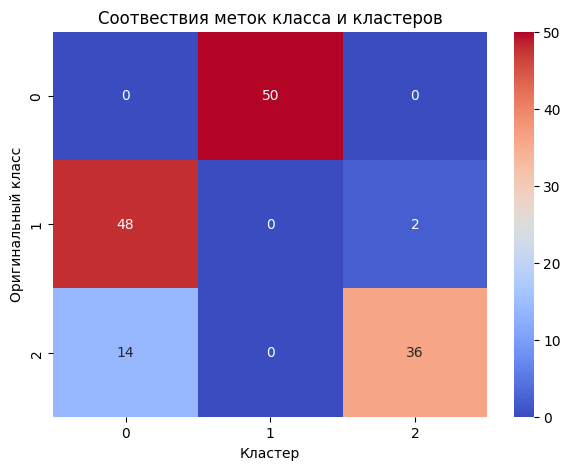

In [ ]:
# Импортируем модификацию библиотеки matplotlib
import seaborn as sns
import pandas as pd

# Преобразуем y и предсказания в формат pandas
original_labels_series = pd.Series(y, name='Оригинальный класс')
clusters_series = pd.Series(clusters, name='Кластер')
df = pd.concat([original_labels_series, clusters_series], axis=1)

# Создаем таблицу
cross_tab = pd.crosstab(df['Оригинальный класс'], df['Кластер'])

# Выводим тепловую карту
plt.figure(figsize=(7, 5))
sns.heatmap(cross_tab, annot=True, cmap='coolwarm')
plt.title("Соотвествия меток класса и кластеров")
plt.show()

## DBSCAN

DBSCAN - алгоритм, основанный на плотности. Алгоритм группирует вместе объекты, которые расположены близко и помечает как выбросы объекты, которые находятся в областях с малой плотностью (ближайшие соседи которых лежат далеко).

Схему его  работы можно разбить на несколько этапов:

1. Начинаем с выбора случайной точки из данных.

2. Находим все точки в заданном радиусе (`eps`) от выбранной точки. Эти точки называются её соседями.

3. Если у точки достаточное количество соседей (больше минимального числа `min_samples`), то она считается ключевой точкой.

4. Если точка является ключевой, то мы расширяем кластер, добавляя всех её соседей в кластер. Также рекурсивно продолжаем этот процесс для соседей.

5. Повторяем шаги 1-4, пока все точки данных не будут обработаны.

6. В результате точки объединяются в кластеры в зависимости от того, с какими ключевыми точками они связаны.

7. Точки, которые не являются частью кластера и не имеют достаточного числа соседей, считаются шумом.

Посмотрим на результаты кластеризации при разном выборе гиперпараметров `eps` и `min_samples`.

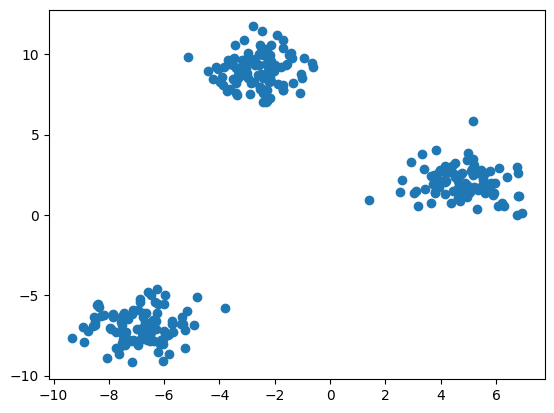

In [ ]:
X, y = make_blobs(n_samples=300, centers=3, random_state=42)
plt.scatter(X[:,0], X[:,1]);

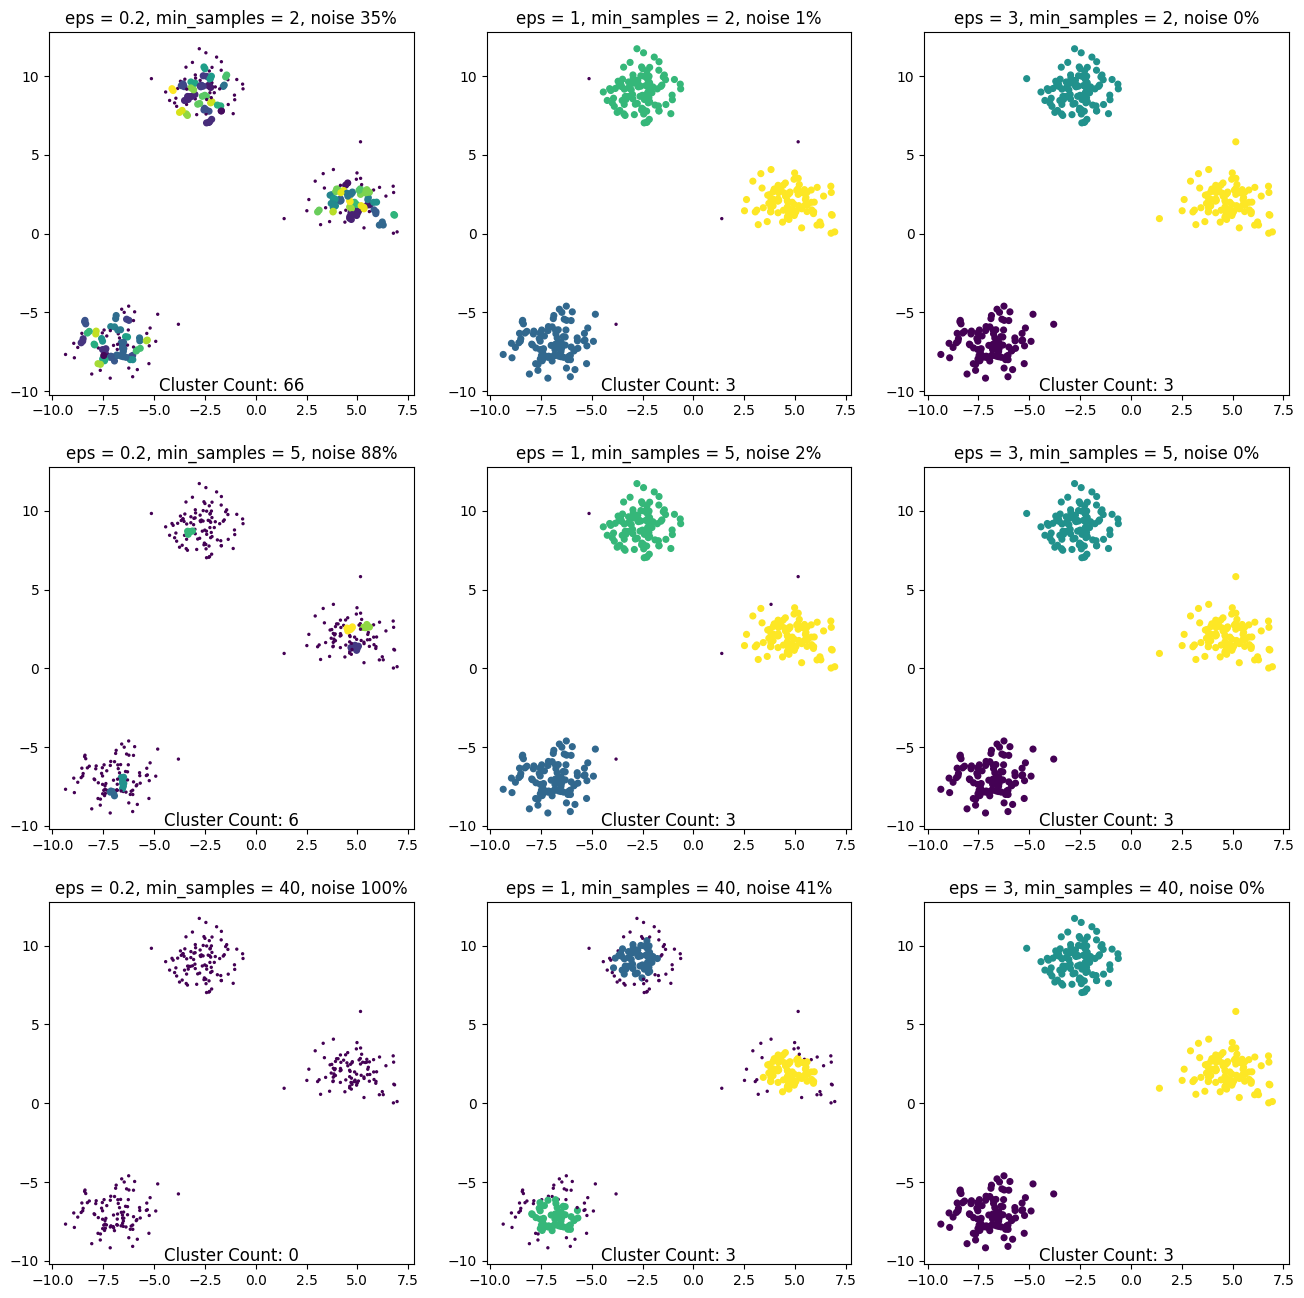

In [ ]:
from sklearn.cluster import DBSCAN

plt.figure(figsize=(16, 16))
i = 1
for min_samples in [2, 5, 40]: # Итерируемся по парамерту min_samples
    for eps in [0.2, 1, 3]: # Итерируемся по размеру окружности
        dbscan = DBSCAN(eps=eps, min_samples=min_samples) # Создаем сам DBSCAN

        # Обучаем и делаем предсказания через одну строчку
        clusters = dbscan.fit_predict(X)

        # Делаем точки кластеров больше, а точки шума меньше
        plt.subplot(3, 3, i)
        plt.scatter(X[:,0], X[:,1], c=clusters, s=15 * (clusters != -1) + 2)
        plt.title('eps = {}, min_samples = {}, noise {:.0f}%'.format(
            eps, min_samples, 100. * np.sum(clusters == -1) / len(X))
        ) # Выводим все показатели

        # Выводим также количество кластеров на график
        cluster_count = len(np.unique(clusters)) - 1 if -1 in clusters \
        else len(np.unique(clusters))
        plt.text(0.5, 0.01, f'Cluster Count: {cluster_count}',
                 transform=plt.gca().transAxes, fontsize=12, ha='center')
        i += 1
plt.show()

Посмотрим как отработают алгоритмы кластеризации K-средних и DBSCAN при другой форме кластеров.

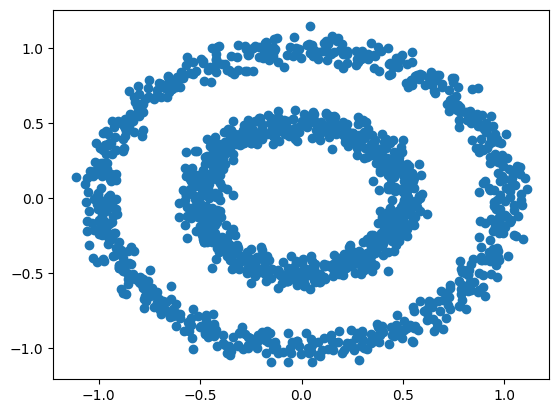

In [ ]:
from sklearn.datasets import make_circles
X = make_circles(n_samples=1500, factor=.5, noise=.05, random_state=42)[0]
plt.scatter(X[:,0], X[:,1]);

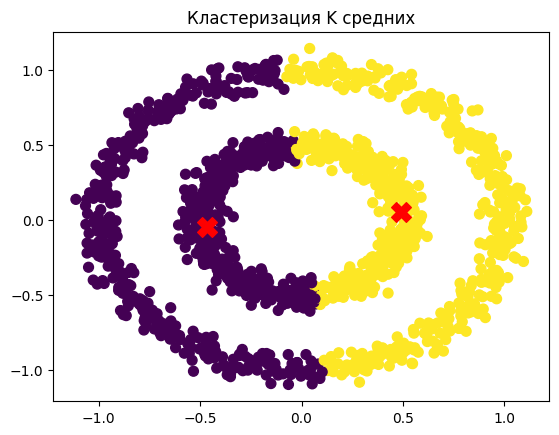

In [ ]:
k_means = KMeans(n_clusters=2, n_init=10, random_state=42)
k_means = k_means.fit(X)
clusters = k_means.predict(X)

# Рисуем график с отображением центров кластеров
cluster_centers = k_means.cluster_centers_
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('Кластеризация K средних')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
            c='red', s=200, marker='X')

plt.show()

## **Задание 2**

Подбор параметров DBSCAN для идеальной кластеризации.

Переберите параметры eps, min_samples и визуально определите лучшие значения.

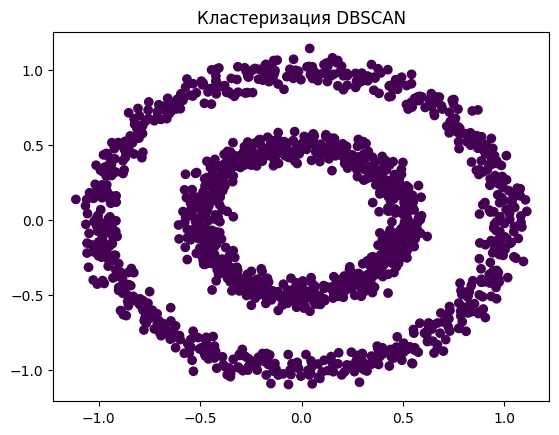

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=2)  # параметры менять здесь
clusters = dbscan.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c = clusters)
plt.title('Кластеризация DBSCAN')
plt.show()

Параметр `eps` можно подобрать и визуально, так как мы можем посмотреть на оси графика и примерно определить расстояние между внешним и внутренним кольцом.

Видно, что DBSCAN хорошо справился с задачей при верном выборе гиперпараметров `eps` и `min_samples`.
K-средних попытался выделить выпуклые области для каждого кластера, и в данном случае не смог выделить кластеры более сложной формы.

Теперь попробуем перебрать 50 значений *eps* в диапазоне 0.01 до 1. А далее построим график, который показывает количество шума и количество классов

In [ ]:
# Пример работы np.linspace
np.linspace(0.01, 1.99, 20) # Создает 20 значений в диапазоне от 0.01 до 1.99

array([0.01      , 0.11421053, 0.21842105, 0.32263158, 0.42684211,
       0.53105263, 0.63526316, 0.73947368, 0.84368421, 0.94789474,
       1.05210526, 1.15631579, 1.26052632, 1.36473684, 1.46894737,
       1.57315789, 1.67736842, 1.78157895, 1.88578947, 1.99      ])

In [ ]:
from sklearn.cluster import DBSCAN
import tqdm # Библиотека для отрисовки progress бара

epss = []
noises = []
counts = []
for eps in tqdm.tqdm(np.linspace(0.01, 1, 50)): # Итерируемся по значениям eps
    dbscan = DBSCAN(eps=eps, min_samples=3)

    # Сохраняем рассчитанные значения
    clusters = dbscan.fit_predict(X)
    epss.append(eps)
    counts.append(len(set(clusters)))
    noises.append(100. * np.sum(clusters == -1) / len(X))

100%|██████████| 50/50 [00:01<00:00, 46.88it/s]


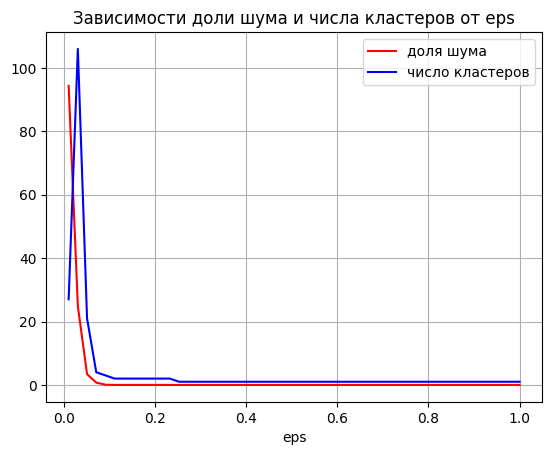

In [ ]:
plt.plot(epss, noises, c='red', label='доля шума')
plt.plot(epss, counts, c='blue', label='число кластеров')

plt.title("Зависимости доли шума и числа кластеров от eps")
plt.grid()
plt.xlabel('eps')
plt.legend()
plt.show()

## Иерархическая кластеризация

Иерархическая кластеризация позволяет группировать объекты (например, точки данных) в иерархическую структуру или дерево, называемое дендрограммой. Этот метод работает путем последовательного объединения близких объектов в кластеры и создания всё более крупных кластеров на каждом шаге. Иерархическая кластеризация может быть агломеративной (сверху вниз) или дивизивной (снизу вверх).

Она позволяет наглядно представить структуру сходства и различий между объектами, а также выявить кластеры различного уровня детализации, что делает её полезной для анализа данных и выявления паттернов.


Принцип работы можно посмотреть на примере точек в двумерном пространстве. Подпишем их буквами

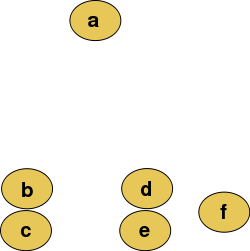

Теперь мы можем применить иерархическую кластеризацию, которая будет постепенно объединять точки.

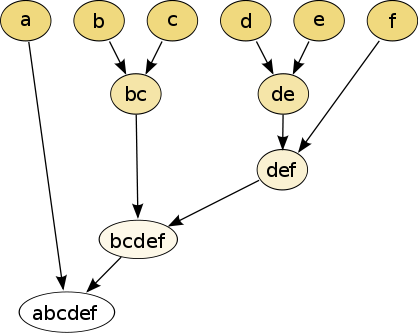

Самые близкие точки по евклидову расстоянию объединились первыми. Далее, зная количество кластеров, мы можем выбрать тот уровень, на котором у нас получается число групп равное числу кластеров.

Посмотрим на то, как она работает на примере сгенерированного набора данных "Луны".

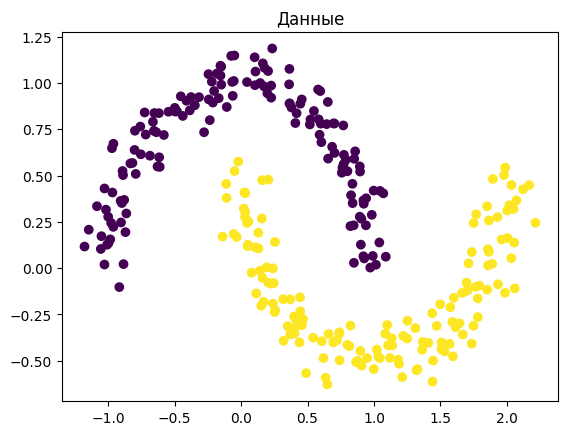

In [ ]:
# Импортируем иерархическую кластеризацию
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=300, noise=0.08, random_state=42)

plt.scatter(X[:,0], X[:,1], c=y)
plt.title('Данные')
plt.show()

Справится ли K-средних с данной задачей?

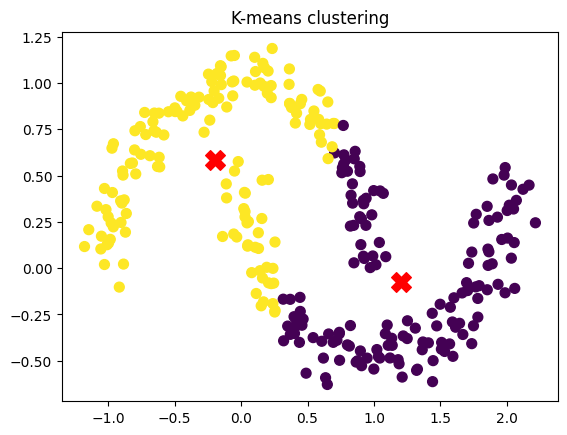

In [ ]:
k_means = KMeans(n_clusters=2, n_init=10, random_state=42)
k_means = k_means.fit(X)
clusters = k_means.predict(X)

# Рисуем график с отображением центров класса
cluster_centers = k_means.cluster_centers_
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('K-means clustering')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
            c='red', s=200, marker='X')

plt.show()

 Кластеризуем данные при помощи агломеративной кластеризации.


In [ ]:
# Передаем два параметра: количество кластеров и linkage
aggl_clust = AgglomerativeClustering(n_clusters=2, linkage="single")

# AgglomerativeClustering при методе fit возвращает нам результат кластеризации
clusters = aggl_clust.fit(X)

Параметр `linkage` определяет, каким образом расстояния между кластерами вычисляются и как выбираются пары кластеров для объединения на каждом этапе.

Посмотрим на результат.

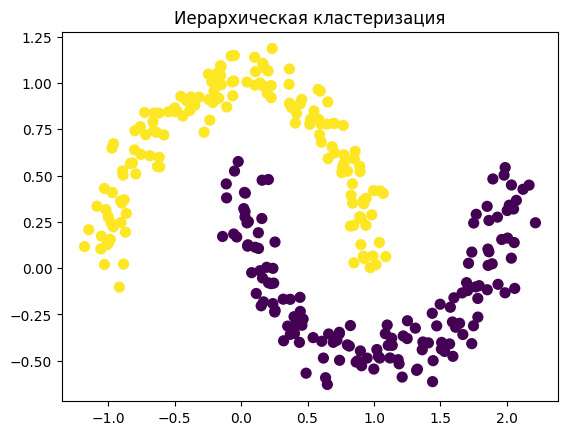

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=clusters.labels_, cmap='viridis', s=50)
plt.title('Иерархическая кластеризация')

plt.show()

Результат сильно зависит от параметра `linkage`. Мы выбрали `single`, он единственный справляется с данными "Луны".

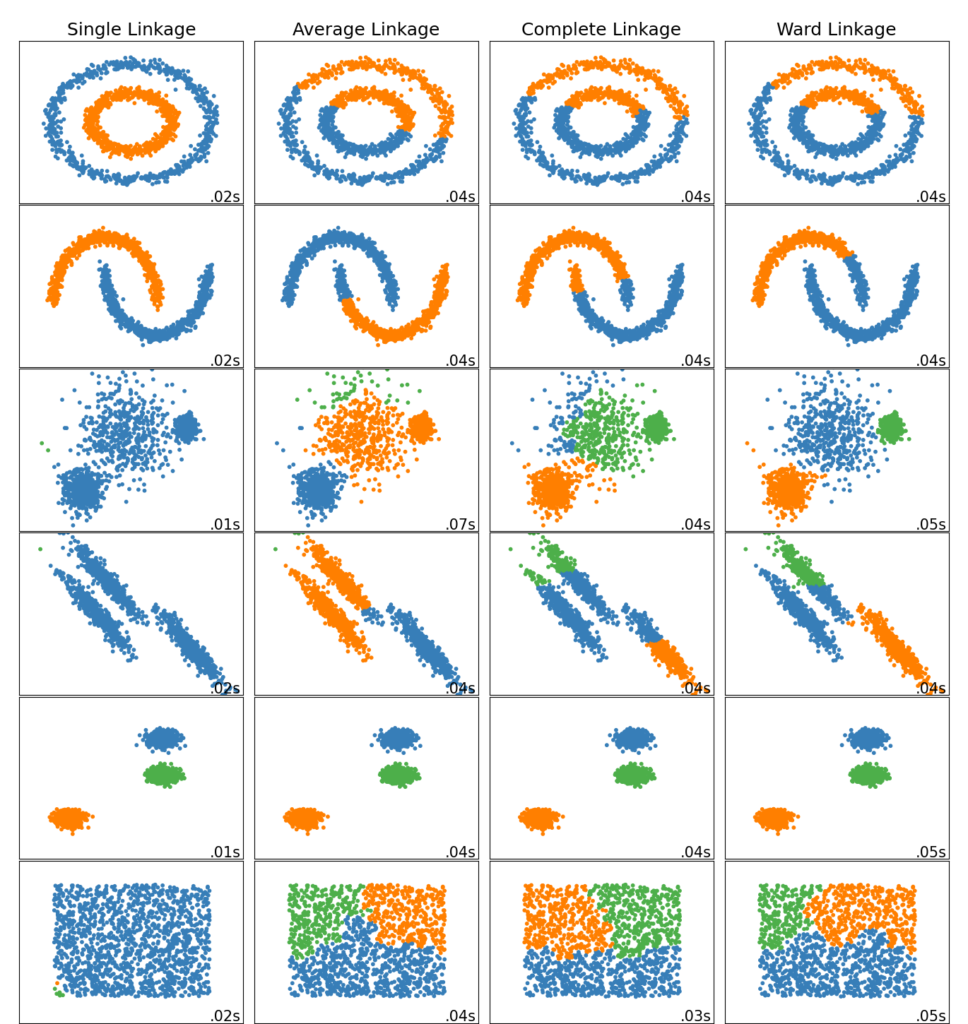

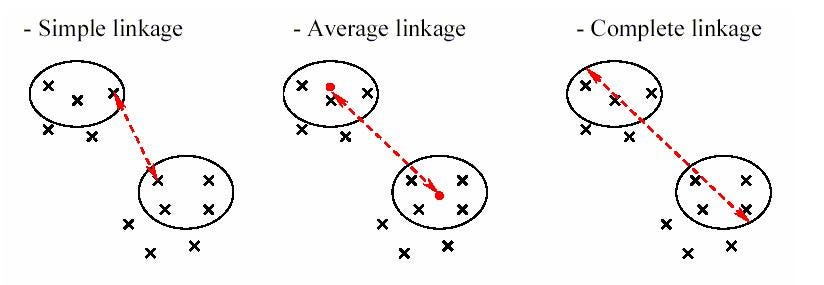

# Данные посложнее - рукописные цифры от 0 до 9.

Рассмотрим образцы рукописного написания цифр.

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits() # Функция для загрузки набора данных цифр
X, y = digits['data'], digits['target']

Одна цифра - массив из 64 значений, показывающих яркость пикселя в каждой конкретной точке.

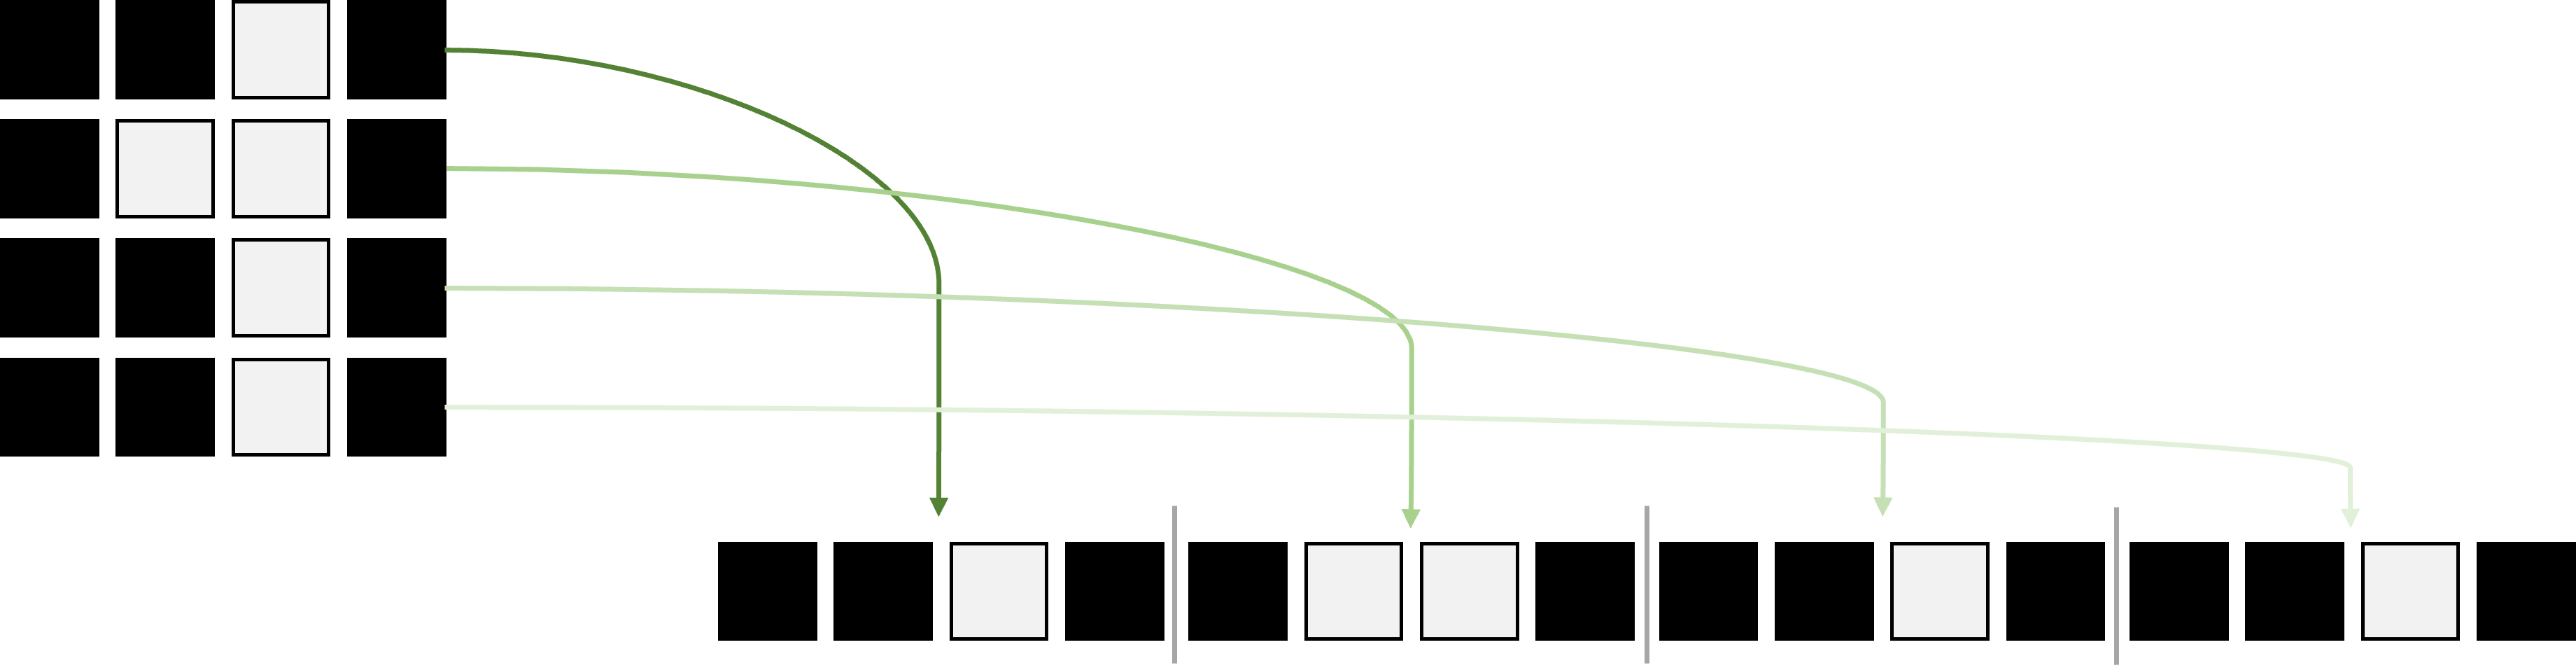

In [ ]:
print(X[0])

[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]


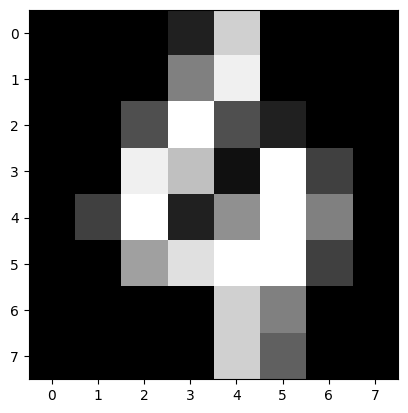

In [ ]:
# Посмотрим на изображение цифры
plt.imshow(X[100].reshape(8, 8), cmap='gray');

## **Задание 3**

Кластеризуйте цифры с помощью алгоритма K-средних. Предсказания для каждой из точек нужно записать в переменную clusters, точно также как ранее. После этого попробуйте оценить, получилось ли кластеризовать цифры. Для этого мы уже импортировали `y`, метки классов для изображений.

In [ ]:
# Ваш код

## Бонус: Измеряем качество кластеризации

Мы знаем настоящую цифру для каждого изображения, поэтому можем проверить качество кластеризации, как долю правильных ответов.

Номера кластеров, которые были предсказаны алгоритмом, не имеют ничего общего с настоящими цифрами.

Посмотрим, какая цифра представлена больше всего в кластере. Будем считать, что это кластер соответствующий этой цифре.

То есть будем считать, что кластер относится к целевому значению $k$, если большинство объектов кластера имеют целевое значение $k$.

In [ ]:
pred = np.zeros(X.shape[0])
for i in range(10):
    bc = np.bincount(y[clusters == i])
    pred[clusters == i] = bc.argmax()

In [ ]:
y[clusters==0]

Измерим качество

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y, pred)

Найдем объекты, которые по ошибке попали в этот класс.

In [ ]:
incorect_indices = np.where(np.logical_and(pred == 4, y != 4))[0]

In [ ]:
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(X[incorect_indices[i]].reshape(8, 8), cmap='gray')
    plt.title("Real digit is {}".format(y[incorect_indices[i]]))

Посмотрим на настоящие цифры.

In [ ]:
corect_indices = np.where(np.logical_and(pred == 4, y == 4))[0]
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(X[corect_indices[i]].reshape(8, 8), cmap='gray')
    plt.title("Real digit is {}".format(y[corect_indices[i]]))

В задачах кластеризации принято использовать специфичные метрики, и мы их далее разберем.

### Метрики качества кластеризации

Для сравнения разных алгоритмов кластеризации также хочется использовать метрики качества, только есть одна проблема: мы не знаем правильных ответов. А если и знаем, номер кластера не бьется с правильным ответом.

Таким образом, у нас есть два проблемных случая:
- мы не знаем в принципе правильного ответа, а хочется как-то оценить качество кластеризации.
- мы знаем правильный ответ, но его трудно сопоставить с номером кластера.

Рассмотрим оба случая:

### Silhouette score (оценка силуэта)

***Случай 1:*** мы не знаем правильных ответов. Если алгоритм кластеризации хороший, то объекты внутри кластера расположены близко, а крайние объекты кластеров расположены далеко друг от друга. Именно на эту идею опирается *силуэтный коэффициент*.

**Силуэтный коэффициент** - метрика, оценивающая сходство объектов внутри кластера и дальность объектов между разными кластерами. Он рассчитывается следующим образом:

Для каждого объекта вычисляется среднее расстояние до других объектов в том же кластере $(a_i)$
Затем для того же объекта вычисляется среднее расстояние до объектов в ближайшем соседнем кластере $(b_i)$

Силуэтный коэффициент для объекта $i$ рассчитывается как:

## $S(i) = \frac{b_i - a_i}{\max(a_i, b_i)}$

Потом усредняем по всем объектам. Высокий общий силуэтный коэффициент указывает на хорошее качество кластеризации, а низкий - на плохое.





In [ ]:
from sklearn.metrics import silhouette_score

print("Средняя оценка силуэта: ", silhouette_score(X, clusters))

Сравним между собой K средних, Иерархическую кластеризацию и DBSCAN на основе оценки силуэта. Параметры для DBSCAN были подобраны заранее, они позволяют кластеризовать на 10 цифр.

In [ ]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans.fit(X)
clusters_kmeans = kmeans.predict(X)

aggl_cluster = AgglomerativeClustering(n_clusters=10)
clusters_aggl = aggl_cluster.fit_predict(X)

dbscan = DBSCAN(eps=9.700909090909091, min_samples=2)
clusters_dbscan = dbscan.fit_predict(X)

print("Средняя оценка силуэта для K средних: ", silhouette_score(X, clusters_kmeans))
print("Средняя оценка силуэта для Иерархической кластеризации: ", silhouette_score(X, clusters_aggl))
print("Средняя оценка силуэта для DBSCAN : ", silhouette_score(X, clusters_dbscan))

Как мы видим, значения K средних и Иерархической кластеризации получились близкими, и сложно определить, какая кластеризация явно лучше. А вот DBSCAN сильно отстает и показывает низкое значение метрики.

### **Задание 4**

Какие значения силуэта получатся, если мы будем перебирать количество кластеров от 2 до 15? Выведите график.



In [ ]:
# Ваше решение тут

### Homogeneity score
Если у нас все-таки есть правильные ответы, то мы можем их сопоставить с кластерами. В этом нам поможет *homogeneity score*.

**Homogeneity score (оценка однородности)** измеряет, насколько объекты в одном кластере, действительно, представляют один и тот же класс данных (*y_true*), и насколько кластеры состоят из схожих объектов. Для каждого кластера вычисляется, какая доля объектов в этом кластере принадлежит к одному классу или категории. А далее усредняем по кластерам.

$$
\text{Homogeneity} = 1 - \frac{H(C|K)}{H(C)}
$$

Где:
- $H(C|K)$ — условная энтропия классов $C$ при заданных кластерах $K$.
- $H(C)$ — энтропия классов $C$.

---

### Условная энтропия $ H(C|K) $

$$
H(C|K) = -\sum_{k=1}^{|K|} \sum_{c=1}^{|C|} \frac{n_{c,k}}{n} \log \left( \frac{n_{c,k}}{n_k} \right)
$$

Где:
- $n_{c,k}$— количество объектов класса $c$ в кластере $k$.
- $n_k$ — общее количество объектов в кластере $k$.
- $n$ — общее количество объектов.

---

### Энтропия $H(C)$

$$
H(C) = -\sum_{c=1}^{|C|} \frac{n_c}{n} \log \left( \frac{n_c}{n} \right)
$$

Где:
- $n_c$ — количество объектов класса $c$.

---

### Интерпретация
- **1** — идеальная однородность: каждый кластер содержит объекты только одного класса.
- **0** — кластеры неоднородны: объекты разных классов смешаны.

---

### Примечание
Homogeneity Score часто используется вместе с **Completeness Score** и **V-measure** для комплексной оценки качества кластеризации.

Homogeneity score принимает значения в диапазоне от 0 до 1, и чем ближе к 1, тем лучше.

In [ ]:
from sklearn.metrics import homogeneity_score

digits = load_digits()
X, y = digits['data'], digits['target']

kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans.fit(X)
clusters = kmeans.predict(X)

print("Средняя оценка однородности: ", homogeneity_score(y, clusters))

Сравним между собой K-средних, Иерархическую кластеризацию и DBSCAN на основе оценки однородности.

In [ ]:
kmeans = KMeans(n_clusters=10, n_init=10, random_state=42)
kmeans.fit(X)
clusters_kmeans = kmeans.predict(X)

aggl_cluster = AgglomerativeClustering(n_clusters=10)
clusters_aggl = aggl_cluster.fit_predict(X)

dbscan = DBSCAN(eps=9.700909090909091, min_samples=2)
clusters_dbscan = dbscan.fit_predict(X)

print("Средняя оценка однородности для K средних: ", homogeneity_score(clusters_kmeans, y))
print("Средняя оценка однородности для Иерархической кластеризации: ", homogeneity_score(clusters_aggl, y))
print("Средняя оценка однородности для DBSCAN : ", homogeneity_score(clusters_dbscan, y))

DBSCAN, как и в прошлый раз, показал самое низкое значение. Оценка однородности помогла нам решить неопределенность оценки силуэта. Теперь мы знаем, что лучший алгоритм для данного набора данных и на основе двух метрик - Иерархическая кластеризация.

## Подбор гиперпараметров Иерархической кластеризации на основе оценки силуэта

Ранее мы изучили оценку силуэта. На ее основе можно перебрать гиперпараметры и выбрать лучшие из них. Возьмем уже знакомый `AgglomerativeClustering` и выберем  лучшие параметры `linkage` и `metric` для кластеризации цифр на основе оценки силуэта. Ранее мы уже обучали его для этих же данных, но не меняли гиперпараметры "по умолчанию" - `linkage="ward"` и `metric="euclidean"`. Оценка коэффициента при таких значениях была `0.178`. Сейчас мы будем пробовать другие гиперпараметры за исключением `linkage="ward"` и посмотрим, вырастет ли метрика.

In [ ]:
best_score = -1
best_params = {}

# Итерируемся по значению размера окружности и минимальному количеству наблюдений
for linkage in ["complete", "average", "single"]:
    for metric in ["euclidean", "l1", "l2", "manhattan", "cosine"]:
        # передаем параметры в модель
        model = AgglomerativeClustering(n_clusters=10, linkage=linkage, metric=metric)
        labels = model.fit_predict(X)

        # Измеряем качество
        silhouette_avg = silhouette_score(X, labels)

        # Если качество лучше чем то, что у нас было ранее - сохраняем
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_params['linkage'] = linkage
            best_params['metric'] = metric

print("Лучший коэффициент силуюта: ", best_score)
print("Лучшие параметры: ", best_params)

Результаты наших подборов оказались хуже, чем при базовых гиперпараметрах. Далее мы можем их не менять и задавать только количество кластеров, а затем исследовать результаты.

# Алгоритмы понижения размерности

С ростом количества собираемой информации, как правило растет и размерность данных. Для каждого наблюдения добавляются различные признаки. При анализе это сильно усложняет задачу, мы уже не можем увидеть данные во всем объеме на одном графике, так как мы ограничены двумерными графиками (иногда трехмерными). Тем не менее, на данные посмотреть хочется. Как раз для этого мы можем применить алгоритмы понижения размерности, которые позволяет нам отобразить размерность в двумерное пространство и посмотреть на графики.

## PCA

Работа алгоритма состоит из нескольких шагов:

1. **Построение матрицы ковариации X:**
    
   $ \text{Cov(X)} = \frac{1}{n-1}(X-\bar{X})^T(X-\bar{X}) $
2. **Расчет собственных векторов и собственных значений матрицы ковариации:**
   
   $ \text{Cov(X)}v = \lambda v $


3. **Определение доли объясненной дисперсии для каждого из собственных значений:**
   
   $ \text{Доля} = \frac{\lambda_i}{\sum_{j=1}^{p}\lambda_j} $

   Здесь $\lambda_i$ - i-е собственное значение, $p$ - общее количество признаков.

4. **Выбор $k$ собственных векторов, лучше всего объясняющих дисперсию:**

   $ \text{Преобразованные данные} = X \cdot V_k $

5. **Расчет общей сохраненной дисперсии:**
   
   $ \text{Общая сохраненная дисперсия} = \sum_{i=1}^{k}\lambda_i $


In [ ]:
from sklearn.datasets import load_digits

digits = load_digits() # Опять загружаем цифры
X, y = digits['data'], digits['target']

Как известно из лекций, PCA позволяет снизить размерность признакового пространства, потеряв наименьшее количество информации.

Применим метод главных компонент к данным про рукописные цифры.

Выберем гиперпараметр `n_components=2` и визуализируем результат.

In [ ]:
%%time
from sklearn.decomposition import PCA

# Задаем класс PCA и указываем там параметр количества главных компонент равный 2
pca = PCA(n_components=2, random_state=42)
digits_2d = pca.fit_transform(X) # Обучаем и трансформируем данные
digits_2d.shape

In [ ]:
%%time
pca = PCA(n_components=2, random_state=42)
digits_2d = pca.fit_transform(X)
digits_2d.shape
plt.figure(figsize=(13,10))
cmap = plt.get_cmap('jet', 10)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(digits_2d[:, 0], digits_2d[:, 1], s=8)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.scatter(digits_2d[:, 0], digits_2d[:, 1], c = y, cmap=cmap, s=8)
plt.colorbar()
plt.show()

## t-SNE

Основная идея t-SNE заключается в том, чтобы отобразить точки из исходного пространства в пространство меньшей размерности таким образом, чтобы сохранить вероятность соседства точек. Это достигается путем определения условной вероятности того, что пара точек схожа в исходном пространстве и в пространстве меньшей размерности. Затем t-SNE минимизирует дивергенцию Кульбака-Лейблера между этими двумя распределениями, регулируя расстояния между точками в пространстве меньшей размерности.

Ключевой момент заключается в том, что t-SNE уделяет больше внимания сохранению относительных расстояний между близкими точками, что позволяет лучше визуализировать кластеры данных в сравнении с другими методами понижения размерности. Он особенно полезен для обнаружения структуры в данных и выявления внутренних закономерностей.

Алгоритм t-SNE должен гораздо лучше показать цифры на графике, применим его.

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
X, y = digits['data'], digits['target']

In [ ]:
%%time
from sklearn.manifold import TSNE

# Создаем алгоритм t-SNE с двумя главными компонентами и перплексией
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
digits_2d = tsne.fit_transform(X)


Perplexity в t-SNE (t-distributed stochastic neighbor embedding) - это гиперпараметр, который влияет на то, как алгоритм размещает точки данных в низкоразмерном пространстве. Он регулирует баланс между сохранением локальной структуры данных (низкая perplexity) и улавливанием глобальных паттернов (высокая perplexity). Выбор правильного значения perplexity может значительно повлиять на результаты t-SNE визуализации данных.

In [ ]:
plt.figure(figsize=(13,10))
cmap = plt.get_cmap('jet', 10)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(digits_2d[:, 0], digits_2d[:, 1], s=2)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.scatter(digits_2d[:, 0], digits_2d[:, 1], c = y, cmap=cmap, s=2)
plt.colorbar()
plt.show()

## Бонус: 3D визуализация 3-х компонент

In [ ]:
%%time
import plotly.express as px

tsne = TSNE(n_components=3, perplexity=50)
X, y = digits['data'], digits['target']
digits_3d = tsne.fit_transform(X)

# Создаем график
fig = px.scatter_3d(
    digits_3d, x=0, y=1, z=2, color=y,
    labels={'0': 'Component 1', '1': 'Component 2', '2': 'Component 3'},
)

# Создаем график
fig.update_layout(
    scene=dict(
        xaxis=dict(showbackground=True, gridcolor="white"),
        yaxis=dict(showbackground=True, gridcolor="white"),
        zaxis=dict(showbackground=True, gridcolor="white"),
    )
)

fig.show()


## **Задание 5**

Определите визуально, сколько кластеров в данных.

Попробуйте PCA и t-SNE.


In [ ]:
import pandas as pd
# скачиваем данные
# http://cs.joensuu.fi/sipu/datasets/dim032.txt
! wget https://www.dropbox.com/s/n4vwlwe395rrwwe/dim032.txt?dl=1 -O dim032.txt
X = pd.read_csv("dim032.txt", sep='   ', header=None).values.reshape(-1, 32)
X.shape

**Давайте попробуем выполнить данное задание с помощью модели Mistral. Чтобы воспользоваться чатом, есть несколько вариантов:**


1. Кликните на данную ссылку https://chat.mistral.ai/;
2. Скопируйте данную ссылку https://chat.mistral.ai/ и вставьте ее в поисковую строку любого адреса;
3. На рабочем столе нажмите на ссылку, которая ведет к чату.

Промпт для модели нужно придумать самим.

In [ ]:
%%time
# Ваше решение тут

# Кластеризация для реальной задачи

Кластеризация кредитных карт - это задача группировки владельцев кредитных карт на основе их покупательских привычек, кредитных лимитов и многих других финансовых факторов. Мы попробуем подробнее разобраться, как применить уже изученные подходы в задаче кластерного анализа. Такой кластерный анализ помогает компаниям находить своих потенциальных клиентов и разрабатывать многие другие маркетинговые стратегии.

Скачаем данные и извлечем их из формата .zip.

In [ ]:
!gdown https://statso.io/wp-content/uploads/2022/11/Credit-card-data.zip

In [ ]:
!unzip /content/Credit-card-data.zip

In [ ]:
import pandas as pd
import numpy as np
from sklearn import cluster

# подгружаем данные с помощью библиотеки pandas
data = pd.read_csv("/content/Credit card data/CC GENERAL.csv")
data.head()

Давайте проверим, содержит ли этот набор данных какие-либо пропущенные значения или нет.

In [ ]:
data.isnull().sum()

В столбце минимальных платежей в наборе данных есть несколько нулевых значений. Давайте удалим эти строки.

In [ ]:
data = data.dropna()

В наборе данных есть три признака, которые очень ценны для задачи сегментации кредитных карт:

**BALANCE**: остаток средств на счетах клиентов кредитных карт.

**PURCHASES**: количество покупок, совершенных со счетов клиентов кредитных карт.

**CREDIT_LIMIT**: лимит кредитной карты.


*Этих трех признаков достаточно, чтобы сгруппировать владельцев кредитных карт, поскольку они сообщают нам историю покупок, банковский баланс и кредитный лимит владельцев кредитных карт.*

In [ ]:
# импортируем библиотеку для нормализации данных
from sklearn.preprocessing import MinMaxScaler

clustering_data = data[["BALANCE", "PURCHASES", "CREDIT_LIMIT"]]

scaler = MinMaxScaler()
clustering_data = scaler.fit_transform(clustering_data)

In [ ]:
from sklearn.cluster import KMeans

# инициализируем метод кластеризации
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(clustering_data)
data["CREDIT_CARD_SEGMENTS"] = clusters

Добавили новый столбец как CREDIT_CARD_SEGMENTS. Он содержит метки о группе клиентов кредитных карт, количество сформированных групп варьируется от 0 до 4. Для простоты изменим названия этих кластеров.

In [ ]:
data["CREDIT_CARD_SEGMENTS"] = data["CREDIT_CARD_SEGMENTS"].map({0: "Cluster 1", 1:
    "Cluster 2", 2: "Cluster 3", 3: "Cluster 4", 4: "Cluster 5"})
print(data["CREDIT_CARD_SEGMENTS"].head(10))

In [ ]:
# импортируем библиотеку для визуализации
import plotly.graph_objects as go

PLOT = go.Figure()
for i in list(data["CREDIT_CARD_SEGMENTS"].unique()):


    PLOT.add_trace(go.Scatter3d(x = data[data["CREDIT_CARD_SEGMENTS"]== i]['BALANCE'],
                                y = data[data["CREDIT_CARD_SEGMENTS"] == i]['PURCHASES'],
                                z = data[data["CREDIT_CARD_SEGMENTS"] == i]['CREDIT_LIMIT'],
                                mode = 'markers',marker_size = 6, marker_line_width = 1,
                                name = str(i)))
PLOT.update_traces(hovertemplate='BALANCE: %{x} <br>PURCHASES %{y} <br>DCREDIT_LIMIT: %{z}')


PLOT.update_layout(width = 800, height = 800, autosize = True, showlegend = True,
                   scene = dict(xaxis=dict(title = 'BALANCE', titlefont_color = 'black'),
                                yaxis=dict(title = 'PURCHASES', titlefont_color = 'black'),
                                zaxis=dict(title = 'CREDIT_LIMIT', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

Посмотрим еще раз детальнее на данные.

In [ ]:
data.head()

Давайте сгруппируем значения по столбцу CREDIT_CARD_SEGMENTS и выведем среднее значение баланса кредитных карт пользователей, которые попали в кластер 1.

In [ ]:
df = data.groupby(["CREDIT_CARD_SEGMENTS"])
df.get_group(('Cluster 1'))['BALANCE'].mean()

Теперь посчитаем средние значения для трех наших целевых признаков по всем созданным кластерам.

## **Задание 6**

В  этом задании необходимо провести аналитику получившихся кластеров. Вам следует сгруппировать данные по кластеру (столбец `CREDIT_CARD_SEGMENTS`), затем рассчитать средние показатели по столбцам `BALANCE`, `PURCHASES`, `CREDIT_LIMIT`.

**Давайте попробуем выполнить данное задание с помощью модели Mistral. Чтобы воспользоваться чатом, есть несколько вариантов:**


1. Кликните на данную ссылку https://chat.mistral.ai/;
2. Скопируйте данную ссылку https://chat.mistral.ai/ и вставьте ее в поисковую строку любого адреса;
3. На рабочем столе нажмите на ссылку, которая ведет к чату.

Промпт для модели нужно придумать самим.

In [ ]:
clust_analysis = # Ваш код здесь
clust_analysis

Давайте построим график изменения среднего баланса кредитных карт, среднего значения покупок и среднего лимита пользователей в зависимости от кластера, в который их отнесли.

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

# строим график для среднего баланса
ax[0].bar(list(range(1, len(clust_analysis['BALANCE']) + 1)), clust_analysis['BALANCE'], color='darkblue')
ax[0].set_xlabel('Кластера', fontsize=14)
ax[0].set_ylabel('Средний баланс', fontsize=14)

# строим график для среднего числа покупок
ax[1].bar(list(range(1, len(clust_analysis['PURCHASES'])+ 1)), clust_analysis['PURCHASES'], color='darkgreen')
ax[1].set_xlabel('Кластера', fontsize=14)
ax[1].set_ylabel('Среднее кол-во покупок', fontsize=14)

# строим график для среднего лимита
ax[2].bar(list(range(1, len(clust_analysis['CREDIT_LIMIT'])+ 1)), clust_analysis['CREDIT_LIMIT'], color='darkred')
ax[2].set_xlabel('Кластера', fontsize=14)
ax[2].set_ylabel('Средний лимит', fontsize=14)

# построим три графика, расположенных по горизонтали
ax[0].set_title('Зависимость среднего баланса от кластера', fontsize=14)
ax[1].set_title('Зависимость среднего числа покупок от кластера', fontsize=14)
ax[2].set_title('Зависимость среднего лимита от кластера', fontsize=14)

fig.suptitle('Анализ кластеров по среднему значению', fontsize=20)
plt.tight_layout()

plt.show()

Какую зависимость можно выявить? Например, если рассматривать кластеры 3 и 5, у них почти одинаковый лимит по кредитной карте, количество покупок различается на 1000 единиц, но вот количество денег на кредитной карте у пользователей 3-го кластера почти в 8 раз превышает баланс пользователей из 5-ого кластера. Можно предположить, что пользователи 3-й группы совершают либо дорогие покупки, либо много маленьких, например, если человек - шопоголик. Тогда наше решение -  давайте порекомендуем этим пользователям кредитную карту с большим лимитом на покупки.

# Бонус: задача детекции аномалий

Задача детекции аномалий (аномалий в данных) - это процесс выявления необычных, редких или некорректных наблюдений в наборе данных, которые отличаются от обычных паттернов. При этом данная задача относится к разделу обучения без учителя.

Попробуем научиться решать эту задачу на данных из банка. Нам нужно будет определять мошенников на основе транзакций пользователей.

In [ ]:
# Загружаем данные
!gdown --id 1blZvWaQhr6aymRZOHe4RU4D2Wju7tmcQ
!unzip /content/fraud_dataset.zip

In [ ]:
# считываем их в формат pandas
import pandas as pd
data = pd.read_csv("/content/creditcard.csv")
data.head()

В данном случае у нас есть метка класса, посмотрим на соотношение мошеннических операций и обычных на гистограмме

In [ ]:
data["Class"].hist();

Гистограмма не показывает, что есть мошеннические наблюдения. Посмотрим просто на цифры количества

In [ ]:
data["Class"].value_counts()

In [ ]:
data["Class"].value_counts(normalize=True)

Разделим данные на обучающие и тестовые, через train_test_split из sklearn

In [ ]:
from sklearn.model_selection import train_test_split

X, y = data.drop(columns="Class"), data["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.7)

X_train.shape, X_test.shape

Isolation Forest - алгоритм для детекции аномалий

Принцип работы алгоритма включает в себя следующие шаги:

1.   **Случайный выбор подвыборки данных**: Алгоритм случайным образом выбирает
небольшие подвыборки данных из всего набора данных.
2.   **Создание деревьев решений**: Для каждой подвыборки данных строится дерево решений, где каждый узел разделяет данные на две подгруппы на основе случайно выбранного признака и порогового значения.
3. **Высота дерева и путь до аномалии**: Высота дерева (количество уровней) служит мерой того, насколько быстро данные делятся на подгруппы. Аномалии обычно требуют меньшего количества разделений для изоляции, поэтому они будут ближе к корню дерева.
4. **Суммирование путей**: Для каждой точки данных измеряется средняя длина пути в деревьях решений. Точки, которые имеют более короткий средний путь, считаются аномалиями, так как их изоляция происходит быстрее.

5. **Пороговое значение**: Пороговое значение определяется на основе средней длины пути для нормальных точек данных. Точки с более короткими путями считаются аномалиями, если их путь короче порога.

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import numpy as np

# Создаем модель
model = IsolationForest(random_state=42, contamination='auto')
model.fit(X_train[y_train!=1])

# Предсказываем аномалии на тестовых данных
y_pred = model.predict(X_test)

# Модель возвращает значение -1 для аномалий и 1 для обычных транзакций
# Преобразуем это значение в 0 для обычных значений и 1 для аномалий
y_pred = np.array([1 if x == -1 else 0 for x in y_pred])

# Рассчитываем таблицу с различными метриками
report = classification_report(y_test, y_pred)
print(report)

Посмотрим, сколько транзакций из тестовых данных наш алгоритм отнес к высокорисковым  

In [ ]:
y_test[y_pred == 1]

А теперь к низкорисковым

In [ ]:
y_test[y_pred == 0]

Теперь посчитаем их соотношение

In [ ]:
len(y_test[y_pred == 1]) / len(y_test[y_pred == 0])

# Итоги

- В данном ноутбуке мы разобрались с реализацией алгоритмов кластеризации на python.
- Научились обучать несколько различных алгоритмов и измерять качество результатов.
- Разобрались с отображением многомерных данных в двумерное пространство.
- Рассмотрели реальный кейс.
- В бонусе рассмотрели задачу детекции аномалий и нашли подозрительные операции в банковских транзакциях.